In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

%matplotlib inline

# Data Processing

In [2]:
curve = np.genfromtxt('pH-curve.csv', delimiter=',')
pH = curve[1:,1]
dpH = np.diff(pH)
volume_added = curve[1:,0]/1000

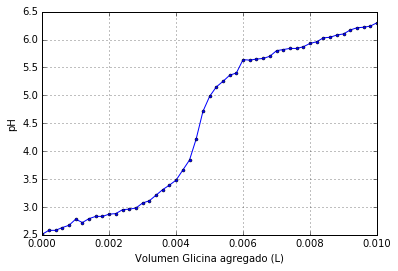

In [3]:
plt.plot(volume_added, pH, "-o", ms=3)
plt.ylabel("pH")
plt.xlabel("Volumen Glicina agregado (L)")
plt.grid()
plt.savefig("images/pH.pdf")

In [4]:
# initial mols
NiCl2 = 0.241/237.69
HNO3 = 0.11*10e-3
KNO3 = 0.2015*100e-3

v_init = (10 + 100 + 90)/1000 # initial volume
volume = volume_added + v_init # global volume

ions = np.array([NiCl2, HNO3, KNO3])
charge = np.array([2, 1, 1])
force = np.zeros_like(volume)

glycine = (0.6005/75.07)/20e-3 # concentration of glycine

for i in range(len(force)):
    gly_added = glycine*volume_added[i] # moles added
    force[i] = np.sum(ions*charge**2/volume[i]) + gly_added/volume[i] # ionic strength

force12 = np.sqrt(force)
gamma = 1/2*(force12/(1+force12))
gamma = 10**(-gamma)

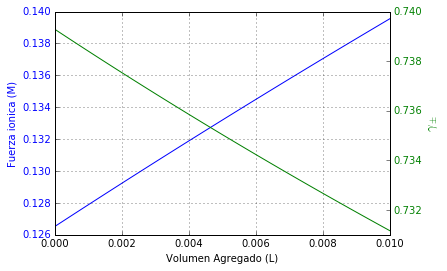

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(volume_added, force, color = 'blue')
ax2.plot(volume_added, gamma, color = 'green')
ax1.set_xlabel('Volumen Agregado (L)')
ax1.set_ylabel('Fuerza ionica (M)', color = 'b')
ax2.set_ylabel('$\gamma_\pm$', color = 'g', fontsize = 13)

for t1 in ax1.get_yticklabels():
    t1.set_color('b')
    
for t2 in ax2.get_yticklabels():
    t2.set_color('g')
    
ax1.grid()
plt.savefig("images/ionic_strength.pdf")

In [6]:
kw = 1.615e-14
H = (10**(-pH))/gamma
OH = kw/H

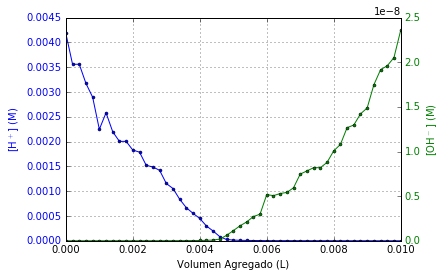

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(volume_added, H, '-o', ms = 3, color = 'blue')
ax2.plot(volume_added, OH, '-o', ms = 3, color = 'green')
ax1.set_xlabel('Volumen Agregado (L)')
ax1.set_ylabel('[H$^+$] (M)', color = 'b')
ax2.set_ylabel('[OH$^-$] (M)', color = 'g')

for t1 in ax1.get_yticklabels():
    t1.set_color('b')
    
for t2 in ax2.get_yticklabels():
    t2.set_color('g')
    
ax1.grid()
plt.savefig("images/HOH.pdf")

In [8]:
Ka = 10**(-9.6)
HA = (HNO3/volume + OH - H)
A = (Ka/H)*HA
n = ((glycine*volume_added)/volume - HA - A)/(NiCl2/volume)

# J. Bjerrum

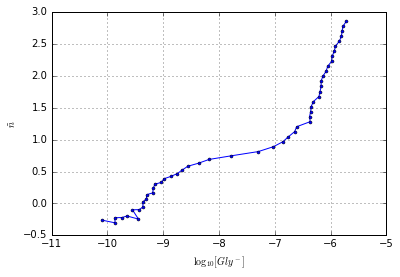

In [9]:
plt.plot(np.log10(A), n, "-o", ms = 3)
plt.xlabel('$\log_{10}[Gly^-]$')
plt.ylabel(r'$\tilde{n}$')
plt.grid()
plt.savefig("images/Bjerrum.pdf")

In [10]:
f = interp1d(n, np.log10(A))
As = np.array([f(0.5), f(1.5), f(2.5)])
As = 10**(As)
exp = np.arange(1,4)
ks1 = 1/(As**exp)
print(ks1)
print(np.log(ks1))

[  4.98915505e+08   5.02860816e+12   4.48003385e+17]
[ 20.02794731  29.24616435  40.64357718]


# Rossotti y Rossotti

In [11]:
pos1 = np.where((n > 0.2) & (n < 0.8))[0]
pos2 = np.where((n > 1.1) & (n < 1.8))[0]

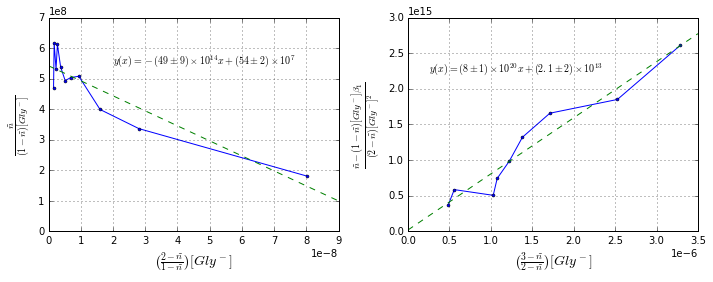

In [12]:
y1 = (n/((1-n)*A))[pos1]
x1 = (A*(2-n)/(1-n))[pos1]

(_, beta1), cov = np.polyfit(x1, y1, 1, cov = True)
x = np.linspace(0, 9e-8, 10)
y = _*x + beta1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.plot(x1, y1, '-o', ms=3)
ax1.plot(x, y, '--')
ax1.set_ylabel(r'$\frac{\tilde{n}}{(1-\tilde{n})[Gly^-]}$', fontsize=14)
ax1.set_xlabel(r'$\left(\frac{2-\tilde{n}}{1-\tilde{n}}\right)[Gly^-]$', fontsize=14)
ax1.text(2e-8, 5.5e8, r"$y(x) = -(49 \pm 9)\times 10^{14} x + (54 \pm 2)\times10^7$")
ax1.grid()

y2 = ((n-(1-n)*beta1*A)/((2-n)*A**2))[pos2]
x2 = (A*(3-n)/(2-n))[pos2]

(beta3, beta2), cov = np.polyfit(x2, y2, 1, cov = True)
x = np.linspace(0, 3.5e-6, 10)
y = beta3*x + beta2

ax2.plot(x2, y2, "-o", ms=3)
ax2.plot(x, y, "--")
ax2.set_ylabel(r'$\frac{\tilde{n}-(1-\tilde{n})[Gly^-]\beta_1}{(2-\tilde{n})[Gly^-]^2}$', fontsize=14)
ax2.set_xlabel(r'$\left(\frac{3-\tilde{n}}{2-\tilde{n}}\right)[Gly^-]$', fontsize=14)
ax2.text(0.25e-6, 2.25e15, r"$y(x) = (8 \pm 1)\times 10^{20} x + (2.1 \pm 2)\times10^{13}$")
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.grid()
plt.tight_layout()
plt.savefig("images/Rossotti.pdf")

In [13]:
print("%.2e %.2e %.2e"%(beta1, beta2, beta3))

k1, k2, k3 = beta1, beta2/beta1, beta3/beta2
k1, k2, k3

5.42e+08 2.09e+13 7.87e+20


(542003112.42448854, 38488.482338521921, 37705884.8418869)